### Enterprise software documentation: workbook

This project joins 4 data sources
- Some broad company metrics (domain Alexa rank, employee numbers etc)
- Documentation website sitemaps (Crawled with SEO software)
- Site text for NLP analyses (Scraped using Beautiful Soup lib)
- Site traffic (Google analytics, one company only)

Project aim
- Competetive analysis: what are the qualities of successful documentation?
- Build a model of the contribution of site factors and audience demand on page traffic (with alexa ranks for cross-company comparison and google analytics data for within-company.
- Use to identify audience demand (popular topics) in real time
- Use to understand which site factors lead to high page traffic (how to surface content to match audience need)

###### Home work 3 
- Clean some sitemaps
    - Non english language content removed from Autodesk
    - Atlassian sitemap crawled on public docs only
    - Microsoft product support docs added with main docs subdomain site to better represent range
        - https://support.office.com/
        - https://support.microsoft.com/
        - https://docs.microsoft.com/
    - Added teradata sitemap for complete set
  
- Takes more columns from the sitemap files e.g. page descriptions/meta data, path depth and link types (inbound, outbount, external)

- I have started collecting the site text for NLP but haven't finished all companies yet

- **KMeans** cluster analysis with silhouette testing
    - this one looks at path depth (articles distance from home page)

- **Decision tree** for web traffic
    - Web traffic is driven by two forces - audience demand and site factors (e.g. SEO, metadata, updates)
    - run this within company docset with available page traffic to model both contributors
            - audience demand by content types (text NLP)
            - site structure from site maps (sitemap data)
    - Decision tree for structuring site content to meet audience demand in real time



###### Workbook steps:
    1. Read in docs sitemaps
        * a) Notes on sitemaps
        * b) Check requests status
        * c) Remove bad requests
        * d) Remove word counts < 50
    2. Format dataframe
        * a) Scatter plots for each company doc set
        * b) Descriptive statistics added to dataframe
    3. Normalise data
        * a) Scatter plot 
    4. Cluster analysis on article length K-means vs DBscan
        * No DBscan on small # (17) of datapoints?
        * test best cluster number for K-means
        * Scatter plots of clusters
    5. Decision tree [not finished]
    6. Compare models [not finished]
    
         

**Content factors**

| Name | Description |
| :------ | :----------------------------- |
| Article length | How long are the articles?, is article length consistent or varied across the site |
| Task focused | How task focused is the text, both words (verbs/nouns) and structure. |
| Verbosity | How long are sentences? Word length, adjectives, common usage, and repetion | 
| Formality | Formal vs informal language, colloquisms, contractions, pronouns etc | 
| Internal Refering | How many links within docs set/doc set size | 
| Outside referals | How many links in the doc refer to external domains/total links | 
| Site bredth & depth | Number of folders, size, depth of path | 
| Topic bredth & depth  | Range of distinct H1,H2, keywords, product folders | 
| Sentiment | How neutral, positive or negetive are the words used? | 
| Formulaic | Are all the articles/folders in the docsset of similar length, structure, tone or are they varied? | 



** Next steps **
- NLP dimensions for above as columns
- Look at within the docs set for clusters
    * Models predicting doc type within a set - dev/admin/KB vs consumer docs,  Microsoft, Atlassian & other sets (that contain diff docs types)
    
      

##### Install python libraries

In [25]:
import numpy as np
from scipy import stats
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import sklearn.linear_model
import sklearn.cluster
import sklearn.datasets
from mpl_toolkits.mplot3d import Axes3D

### 1. Read in docs sitemaps
**a) Notes on sitemaps**
- Read sitemaps for Fortune 500 consumer enterprise software companies with proportion of software revenue >75% + Atlassian and some smaller single product companies
- Maps made with web crawler GUI 'Screaming frog SEO' https://www.screamingfrog.co.uk/
- Easy to monitor & control (pause, save) massive website crawls (Atlassian CAC took 12 hours +)
- In the terminal/bash command window type 'defaults write uk.co.screamingfrog.seo.spider Memory 8g' to allocate lots of memory while running big crawls
- Filter map for HTML only (can filter for pdf later) and export as .csv file

List of sitemap urls & csv files
- Games, entertainment docs excluded
- Also excluded are docs sets behind a login
- Autodesk has non-english language directories sitting on the same level as enmglish content which will need to be removed
- **Note** Read-ins take two runs on initial load for some reason

In [26]:
# Fortune 500 top 5 enterprise software companies sw revenue >75%
smap01a = pd.read_csv('data/docsurls_microsoft.csv') # [√] https://docs.microsoft.com/en-us/
smap01b = pd.read_csv('data/docsurls_microsoftOffice.csv') # [√] https://support.office.com
frms01 = [smap01a,smap01b] 
smap02 = pd.read_csv('data/docsurls_oracle.csv') # [√] https://docs.oracle.com/en/
smap03 = pd.read_csv('data/docsurls_salesforce.csv') # [√] https://help.salesforce.com/
smap04 = pd.read_csv('data/docsurls_symantec.csv') # [√] https://support.symantec.com/en_US/
smap05a = pd.read_csv('data/docsurls_adobe_p1.csv') # [√] https://docs.adobe.com/
smap05b = pd.read_csv('data/docsurls_adobe_p2.csv')
frms05 = [smap05a,smap05b] 
smap06 = pd.read_csv('data/docsurls_intuit.csv') # [√] https://community.intuit.com/ or https://developer.intuit.com/docs/
smap07 = pd.read_csv('data/docsurls_CA.csv') # [BTW?] http://www.ca.com/us/support/ca-support-online/
smap08a = pd.read_csv('data/docsurls_teradata_p1.csv') # [√] http://www.info.teradata.com/
smap08b = pd.read_csv('data/docsurls_teradata_p2.csv') # [√] http://www.info.teradata.com/
smap08c = pd.read_csv('data/docsurls_teradata_p3.csv') # [√] http://www.info.teradata.com/
frms08 = [smap08a,smap08b,smap08c] 
smap09 = pd.read_csv('data/docsurls_autodesk_EN.csv') # [√] https://knowledge.autodesk.com/support
smap10 = pd.read_csv('data/docsurls_synopsis.csv') # [BTW?] http://www.synopsys.com/Support/
smap11 = pd.read_csv('data/docsurls_akamai.csv') # [BTW?] https://developer.akamai.com/
smap12 = pd.read_csv('data/docsurls_nuance.csv') # [BTW?] http://www.nuance.com/support/

In [27]:
# Atlassian and single-product competitors
smap13 = pd.read_csv('data/docsurls_atlassian_PUB.csv') # [√] https://confluence.atlassian.com/
smap14 = pd.read_csv('data/docsurls_trello.csv') # [√] http://help.trello.com/
smap15 = pd.read_csv('data/docsurls_slack.csv') # [√] https://get.slack.help/
smap16 = pd.read_csv('data/docsurls_github.csv') # [√] https://help.github.com/ or https://guides.github.com/
smap17 = pd.read_csv('data/docsurls_dropbox.csv') # [√] https://www.dropbox.com/help
#smap18 = pd.read_csv('data/docsurls_atlassianDAC.csv') # [] https://developer.atlassian.com/

In [28]:
smap01 = pd.concat(frms01)
smap05 = pd.concat(frms05)
smap08 = pd.concat(frms08)

In [76]:
smap_idx = [smap01,smap02,smap03,smap04,smap05,smap06,smap07,smap08,smap09,smap10,smap11,smap12,smap13,smap14,
            smap15,smap16,smap17]
name_idx = ['Microsoft','Oracle','Salesforce','Symantec', 'Adobe','Inuit','CA','Teradata','Autodesk',
           'Synopsis','Akamai','Nuance','Atlassian','Trello','Slack','GitHub','Dropbox']
clen = len(smap_idx)
print 'Number of company docs:', clen

Number of company docs: 17


**b) Remove bad links and <50 word pages**
- 200, 302 vs other
- Look at request status and remove bad requests from docs sets

In [30]:
tmpcnt = {}
tmpok = {}
tmpbad = {}
for k in range(0,clen):
    tmpsmp = smap_idx[k]
    c = Counter(tmpsmp['Status'])
    tmpcnt[k] = len(tmpsmp['Status'])
    tmpok[k] = c['OK'] or c['Found']
    tmpbad[k] = tmpcnt[k]-tmpok[k]
for r in range(1,clen):
    tmp = smap_idx[r]
    tmpidx = tmp[tmp['Status']=='OK']
    smap_idx[r] = tmpidx

** c) Remove word counts < 50 **

In [31]:
for p in range(0,clen):
    tmp = smap_idx[p]
    tmpidx = tmp[tmp['Word Count']>51]
    smap_idx[p] = tmpidx

**d) Number of html pages in each doc site**
How many html files are there? 

In [32]:
slen = 0
savelen = {}
for n in range(0,len(smap_idx)):
    slen = slen + len(smap_idx[n])
    savelen[n] = len(smap_idx[n])
pages = {'pages':savelen}
docpagecnt = pd.DataFrame(pages)
print 'Total html pages counted: ',slen

Total html pages counted:  301406


** e) Graph total docs pages**

Number of companies: 17


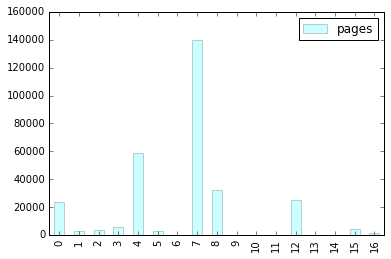

In [114]:
docpagecnt.plot.bar(color='cyan', alpha=0.2)
print 'Number of companies:', len(smap_idx)

### 2. Format dataframe

In [192]:
comps = pd.read_csv('data/ent_softwarecompanies.csv')
r01 = comps[comps['Company']=='Microsoft']
r02 = comps[comps['Company']=='Oracle']
r03 = comps[comps['Company']=='Salesforce']
r04 = comps[comps['Company']=='Symantec']
r05 = comps[comps['Company']=='Adobe']
r06 = comps[comps['Company']=='Intuit']
r07 = comps[comps['Company']=='CA']
r08 = comps[comps['Company']=='Teradata']
r09 = comps[comps['Company']=='Autodesk']
r10 = comps[comps['Company']=='Synopsis']
r11 = comps[comps['Company']=='Akamai']
r12 = comps[comps['Company']=='Nuance']
r13 = comps[comps['Company']=='Atlassian']
r14 = comps[comps['Company']=='Trello']
r15 = comps[comps['Company']=='Slack']
r16 = comps[comps['Company']=='Github']
r17 = comps[comps['Company']=='Dropbox']
df = pd.DataFrame()
cdf = []
cdf = df.append([r01,r02,r03,r04,r05,r06,r07,r08,r09,r10,r11,r12,r13,r14,r15,r16,r17])
cdf.index = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]

In [194]:
#cdf

** Look at: path depth and inlinking **
- Look at how relationship between number of internal links and path depth of the article/ website. 
- Path depth means the number of steps (clicks) away from the home page

In [207]:
avgX = {}
sumX = {}
xtmpX = {}
xtmpY = {}
bins=50
for w in range(0,len(smap_idx)):
    tmp = smap_idx[w]
    #xtmp[w] = np.array(tmp['Word Count'])
    xtmpX[w] = np.array(tmp['Level'])
    xtmpY[w] = np.array(tmp['Inlinks'])
    #color = cols[w]    
    sumX[w] = sum(xtmpX[w])
    avgX[w] = tmp['Level'].mean()
print 'Level average for the websites: ', avgX

Level average for the websites:  {0: 7.6891466821007075, 1: 3.2659970238095237, 2: 7.076317859952793, 3: 7.524192301746792, 4: 7.425128830908883, 5: 7.376099549452907, 6: 3.2318339100346023, 7: 3.768472881347311, 8: 9.451999188146946, 9: 5.1464019851116625, 10: 2.484076433121019, 11: 2.5, 12: 4.984129444821238, 13: 2.165680473372781, 14: 4.791390728476821, 15: 7.9742610555258535, 16: 2.7725674091441967}


** a) Plot doc set factors: path depth**

In [208]:
# Gradient colour array useful for clustering groups
cols_hex = np.array(['#E50004','#E22B00','#DF5B00','#DD8900','#DAB700','#CDD800','#9CD500','#6DD300','#3FD000','#12CE00'
              ,'#00CB19','#00C944','#00C66E','#00C496','#00C1BE','#0098BF','#007EBF'])
#,'#0065BF','#004BBF','#0032BF','#0018BF','#0000BF','#1900BF','#3300BF','#4C00BF','#6500BF'
c = cols_hex

In [211]:
# Update the axis labels for the cluster variable
xlab = 'Path level'
ylab = 'Inlinks'

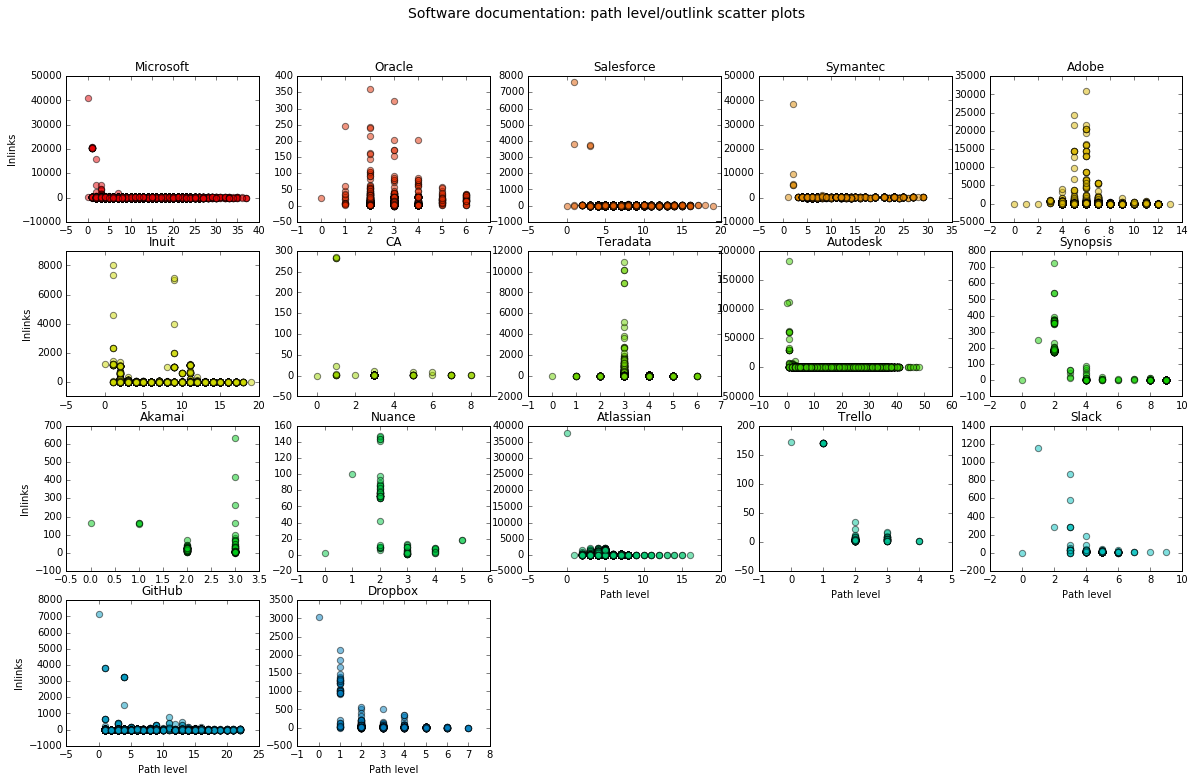

In [212]:
plt.figure(figsize=(20, 12))
plt.suptitle('Software documentation: path level/outlink scatter plots',  fontsize=14)
plt.subplot(451)
plt.scatter(xtmpX[0], xtmpY[0], s=40, color=c[0], alpha=0.5, edgecolors='black', label=name_idx[0])
plt.ylabel(ylab)
#plt.xlim(0, 20)
#plt.ylim(-1, 1)
plt.title(name_idx[0])
plt.subplot(452)
plt.scatter(xtmpX[1], xtmpY[1], s=40, color=c[1], alpha=0.5, edgecolors='black', label=name_idx[1])
plt.title(name_idx[1])
plt.subplot(453)
plt.scatter(xtmpX[2], xtmpY[2], s=40, color=c[2], alpha=0.5, edgecolors='black', label=name_idx[2])
plt.title(name_idx[2])
plt.subplot(454)
plt.scatter(xtmpX[3], xtmpY[3], s=40, color=c[3], alpha=0.5, edgecolors='black', label=name_idx[3])
plt.title(name_idx[3])
plt.subplot(455)
plt.scatter(xtmpX[4], xtmpY[4], s=40, color=c[4], alpha=0.5, edgecolors='black', label=name_idx[4])
plt.title(name_idx[4])
plt.subplot(456)
plt.scatter(xtmpX[5], xtmpY[5], s=40, color=c[5], alpha=0.5, edgecolors='black', label=name_idx[5])
plt.ylabel(ylab)
plt.title(name_idx[5])
plt.subplot(457)
plt.scatter(xtmpX[6], xtmpY[6], s=40, color=c[6], alpha=0.5, edgecolors='black', label=name_idx[6])
plt.title(name_idx[6])
plt.subplot(458)
plt.scatter(xtmpX[7], xtmpY[7], s=40, color=c[7], alpha=0.5, edgecolors='black', label=name_idx[7])
plt.title(name_idx[7])
plt.subplot(459)
plt.scatter(xtmpX[8], xtmpY[8], s=40, color=c[8], alpha=0.5, edgecolors='black', label=name_idx[8])
plt.title(name_idx[8])
plt.subplot(4,5,10)
plt.scatter(xtmpX[9], xtmpY[9], s=40, color=c[9], alpha=0.5, edgecolors='black', label=name_idx[9])
plt.title(name_idx[9])
plt.subplot(4,5,11)
plt.scatter(xtmpX[10], xtmpY[10], s=40, color=c[10], alpha=0.5, edgecolors='black', label=name_idx[10])
plt.ylabel(ylab)
plt.title(name_idx[10])
plt.subplot(4,5,12)
plt.scatter(xtmpX[11], xtmpY[11], s=40, color=c[11], alpha=0.5, edgecolors='black', label=name_idx[11])
plt.title(name_idx[11])
plt.subplot(4,5,13)
plt.scatter(xtmpX[12], xtmpY[12], s=40, color=c[12], alpha=0.5, edgecolors='black', label=name_idx[12])
plt.xlabel(xlab)
plt.title(name_idx[12])
plt.subplot(4,5,14)
plt.scatter(xtmpX[13], xtmpY[13], s=40, color=c[13], alpha=0.5, edgecolors='black', label=name_idx[13])
plt.xlabel(xlab)
plt.title(name_idx[13])
plt.subplot(4,5,15)
plt.scatter(xtmpX[14], xtmpY[14], s=40, color=c[14], alpha=0.5, edgecolors='black', label=name_idx[14])
plt.xlabel(xlab)
plt.title(name_idx[14])
plt.subplot(4,5,16)
plt.scatter(xtmpX[15], xtmpY[15], s=40, color=c[15], alpha=0.5, edgecolors='black', label=name_idx[15])
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title(name_idx[15])
plt.subplot(4,5,17)
plt.scatter(xtmpX[16], xtmpY[16], s=40, color=c[16], alpha=0.5, edgecolors='black', label=name_idx[16])
plt.xlabel(xlab)
plt.title(name_idx[16])
plt.savefig('graphs/ALL_ScatterPlots_LINKS_01.png')
plt.show()

** b) Descriptive statistics to add to dataframe**

In [213]:
max = len(smap_idx)
means = {}
outlinks = {}
inlinks = {}
extoutlinks = {}
variances = {}
skewnesss = {}
kurtosiss = {}
pathdepth = {}
for s in range(0,max):
    tmp = {}
    tmp = smap_idx[s]
    sd = stats.describe(tmp['Word Count'])
    sd1 = stats.describe(tmp['Outlinks'])
    sd2 = stats.describe(tmp['Inlinks'])
    sd3 = stats.describe(tmp['External Outlinks'])
    sd4 = stats.describe(tmp['Level'])
    #print sd.mean, sd.variance
    means[s] = sd.mean
    variances[s] = sd.variance
    skewnesss[s] = sd.skewness
    kurtosiss[s] = sd.kurtosis
    outlinks[s] = sd1.mean
    inlinks[s] = sd2.mean
    extoutlinks[s] = sd3.mean
    pathdepth[s] = sd4.mean

In [214]:
# Add stats to main dataframe

In [215]:
tc = pd.Series(gwc)
sl = pd.Series(savelen)
awc = pd.Series(means)
wcv = pd.Series(variances)
wcs = pd.Series(skewnesss)
wck = pd.Series(kurtosiss)

In [216]:
cdf['docs_total_pages']=sl
cdf['docs_total_words']=tc
cdf['docs_artlen_mean']=awc
cdf['docs_artlen_variance']=wcv
cdf['docs_artlen_skewness']=wcs
cdf['docs_artlen_kurtosis']=wck

In [217]:
ol = pd.Series(outlinks)
il = pd.Series(inlinks)
eol = pd.Series(extoutlinks)
plvl = pd.Series(pathdepth)
cdf['Outlinks']=ol
cdf['Inlinks']=il
cdf['ExtOutlinks']=eol
cdf['PathDepth']=plvl

In [218]:
ndf = pd.DataFrame(cdf)
droplist = ['Company', 'Index','shareticker','shareprice','RevenueM2015','Website','Documentation','Type','ProductList']
ndf.drop(ndf[droplist],inplace=True,axis=1)
#ndf.dropna()

### 3. Normalise data
- have a look at the normalised data

In [219]:
from sklearn import preprocessing
normdf = ndf
print len(ndf)
for k in range(0,13):
    x = ndf[ndf.columns[k]]
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    nm = str(ndf.columns[k])
    print nm
    normdf[nm] = df_normalized

17
Employees
AlexaRank
Products
docs_total_pages
docs_total_words
docs_artlen_mean
docs_artlen_variance
docs_artlen_skewness
docs_artlen_kurtosis
Outlinks
Inlinks
ExtOutlinks
PathDepth


/Users/aparker/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/aparker/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/aparker/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/aparker/ana

** a) Normalised scatter plot **

In [220]:
#normdf

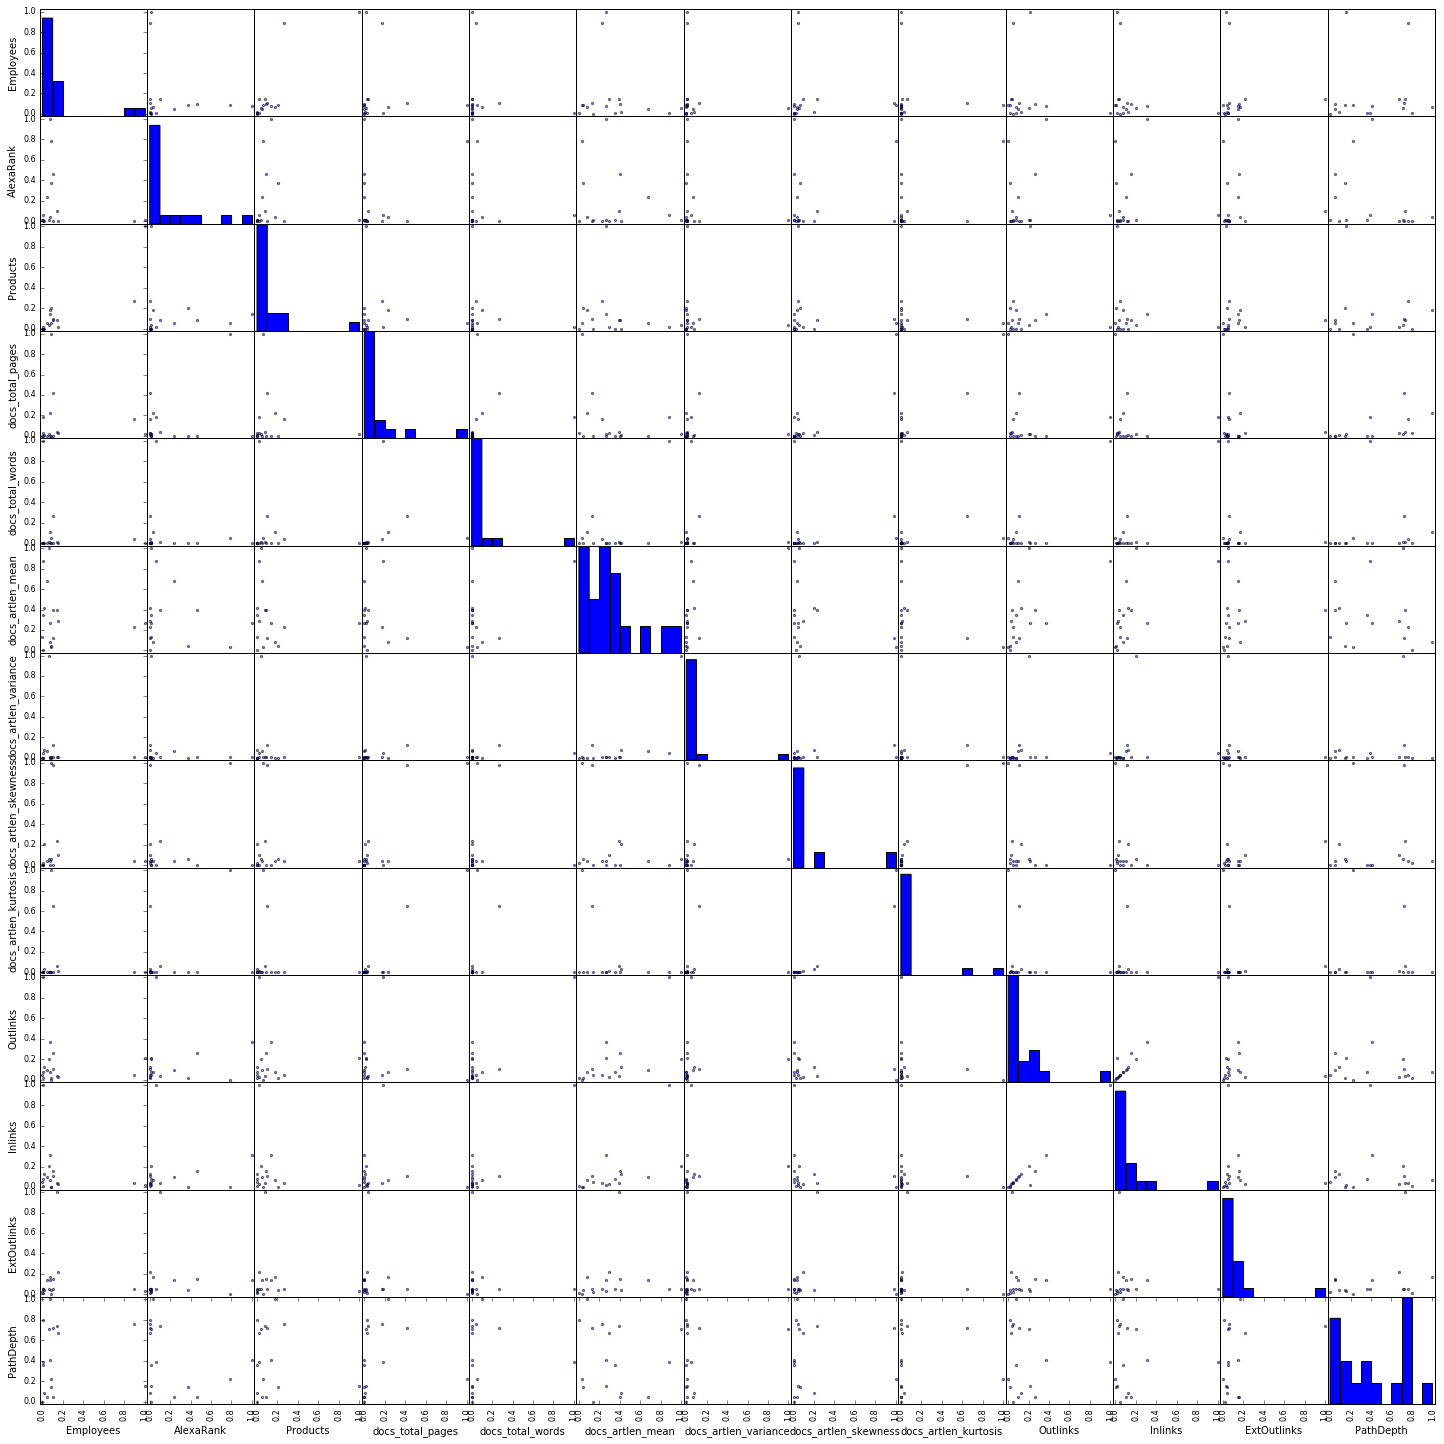

In [222]:
#normdf check plot is the same
fig = pd.scatter_matrix(normdf, figsize=(25,25))
#fig.suptitle('Enterprise software companies - normalised scatter plots', fontsiz=14, fontweight='bold')
plt.savefig('graphs/ALL_ScatterPlotsNorm_01.png')

### 4. Cluster analysis
- Cluster analysis on path depth 

In [234]:
Dfrm = normdf # normalised data \\ 'cdf' for raw
colsdiv = np.array(['#E50004','#DD8900','#9CD500','#12CE00','#00C66E','#0098BF','Blue']) # make cols_hex/ n_clusters
clustdf = pd.DataFrame(data = [Dfrm['PathDepth'], Dfrm['Inlinks']])
# ,ndf['Outlinks']  ,ndf['docs_artlen_mean'], ,ndf['AlexaRank']
cldf = pd.DataFrame.transpose(clustdf)
X = cldf
X

,PathDepth,Inlinks
0,0.758060,0.043022
1,0.151011,0.015312
2,0.673953,0.027654
3,0.735421,0.035975
4,0.721825,0.110115
5,0.715096,0.204390
6,0.146323,0.001107
7,0.219973,0.000000
8,1.000000,0.068867
9,0.409085,0.308131


In [224]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
import sklearn.metrics
import matplotlib.cm as cm

** a) Kmeans clustering and silhouette analysis **
Uses the example and graphs from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

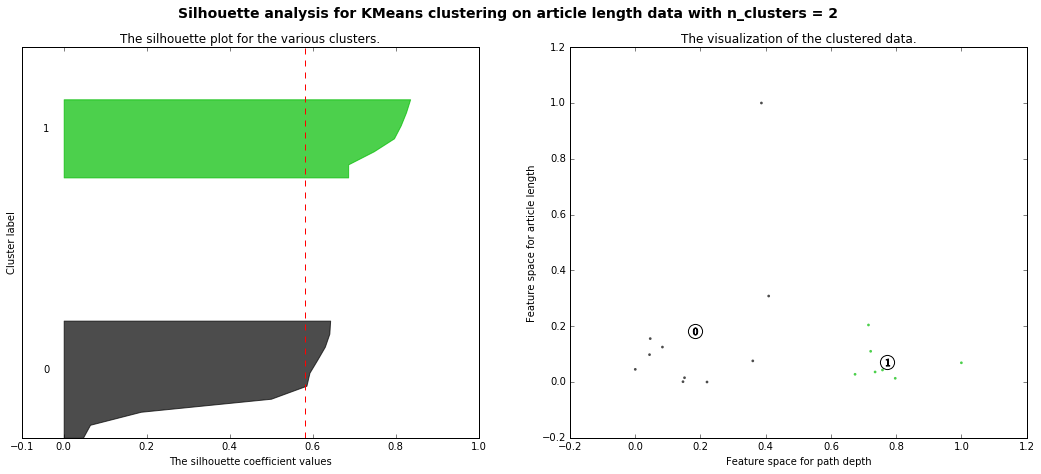

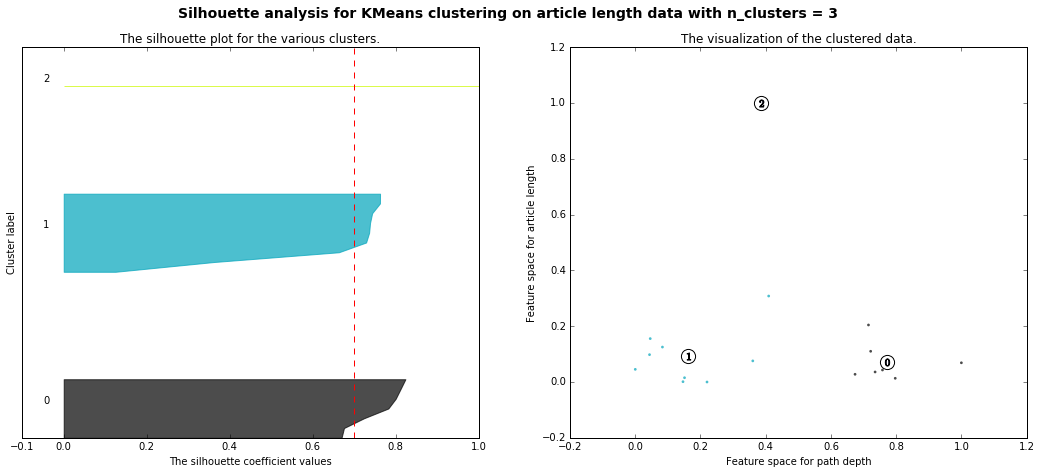

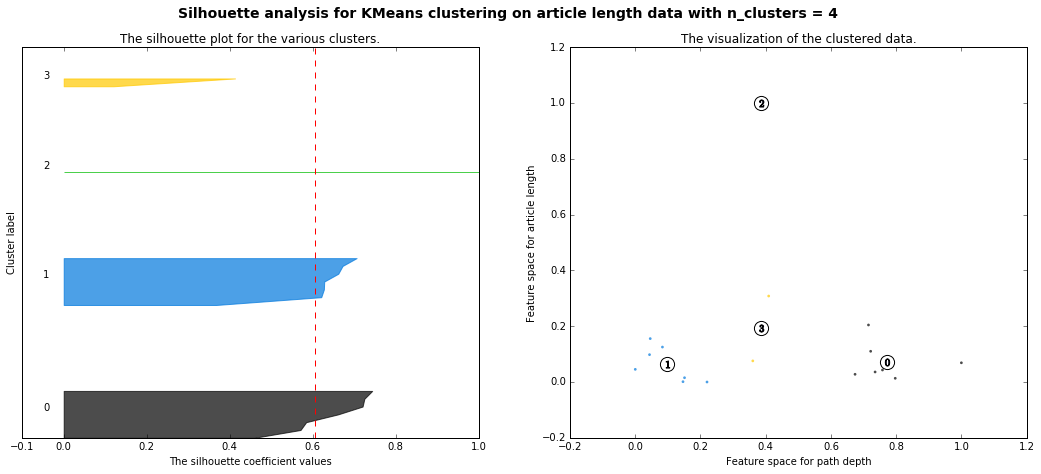

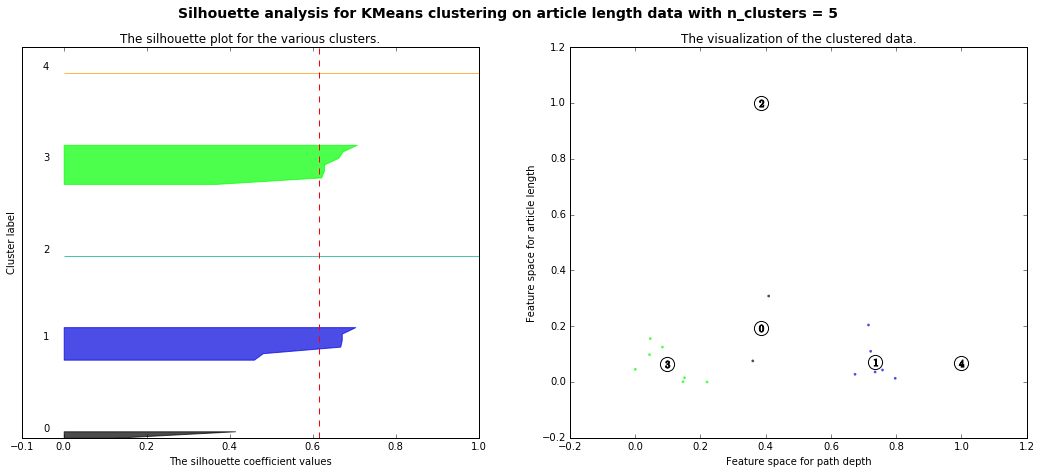

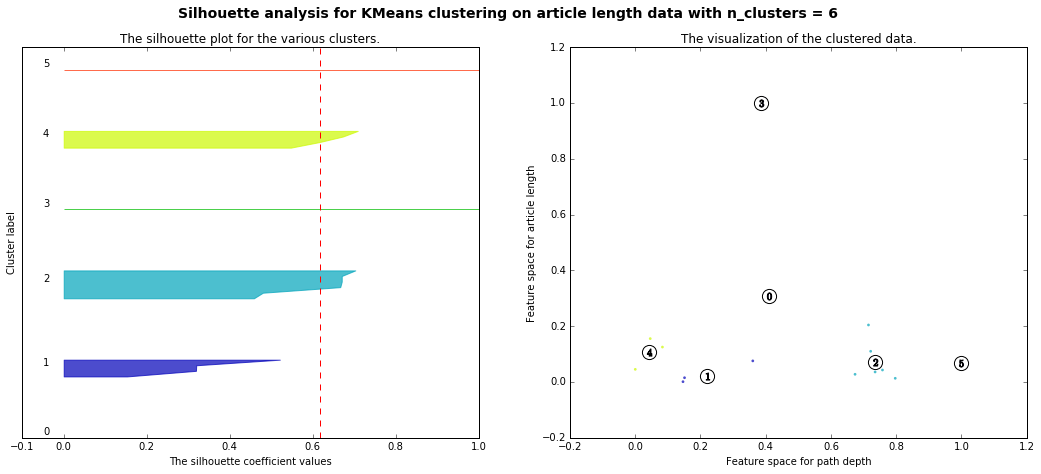

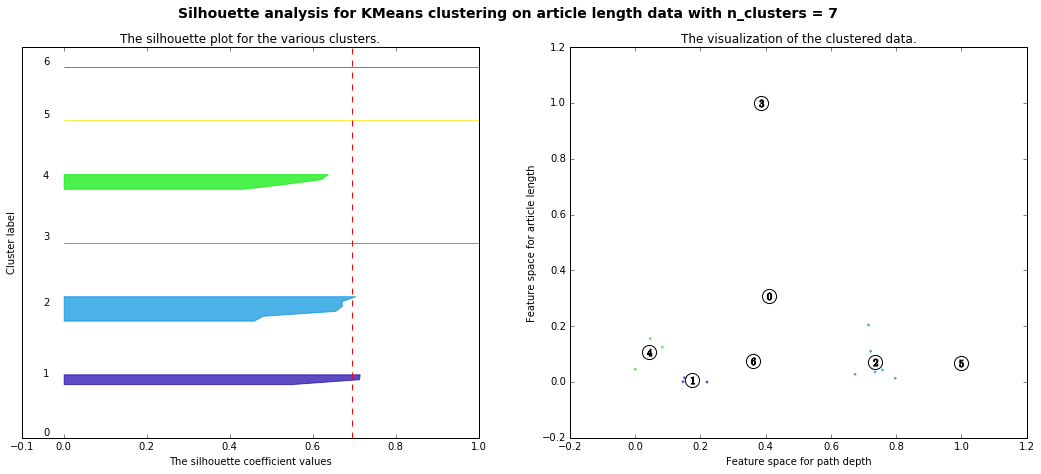

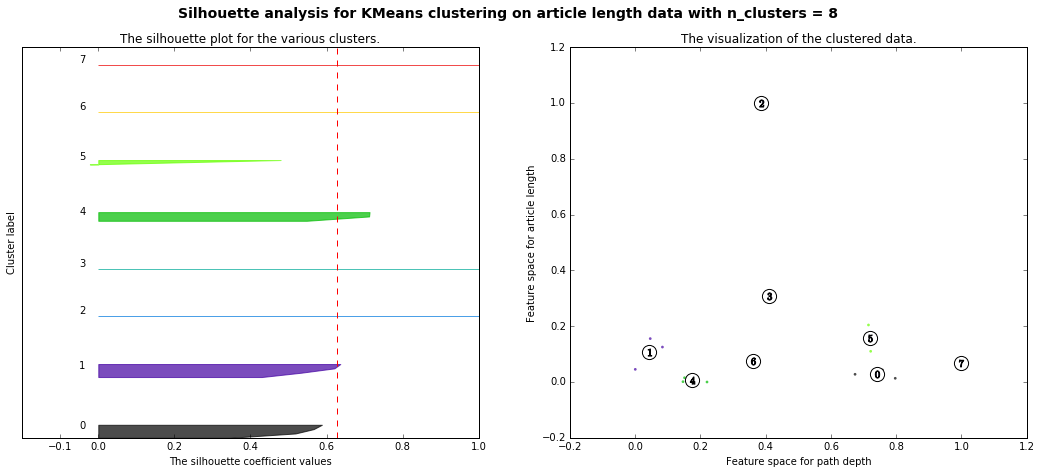

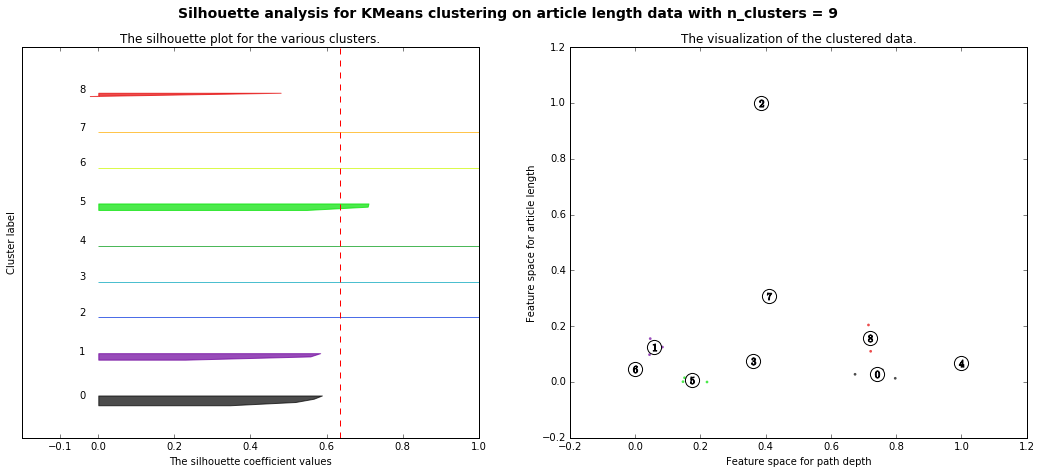

In [226]:
clust_array = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    clust_array.append({'cnum':n_clusters,'centers':clusterer.cluster_centers_,'labels':cluster_labels,'silscore':silhouette_avg})
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples       
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X['PathDepth'], X['Inlinks'], marker='.', s=30, lw=0, alpha=0.7,
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
    # Labeling the clusters
    centers = clusterer.cluster_centers_  
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for path depth")
        ax2.set_ylabel("Feature space for inlinks")
        plt.suptitle(("Silhouette analysis for KMeans clustering on article length data "
                  "with n_clusters = %d" % n_clusters % silhouette_avg),
                 fontsize=14, fontweight='bold')
        filnum = str(n_clusters)
        plt.savefig('graphs/ALL_ClusterTests_Clust_No-'+filnum+'.png')
    plt.show()

In [227]:
sildf = pd.DataFrame(clust_array)
sildf

,centers,cnum,labels,silscore
0,"[[0.184643934505, 0.182437399238], [0.77164935...",2,"[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.581071
1,"[[0.771649358885, 0.0719054472303], [0.1621806...",3,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, ...",0.700229
2,"[[0.771649358885, 0.0719054472303], [0.0985970...",4,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 3, 1, 1, 2, 1, 3, ...",0.604503
3,"[[0.384723204289, 0.191896905979], [0.73359091...",5,"[1, 3, 1, 1, 1, 1, 3, 3, 4, 0, 3, 3, 2, 3, 0, ...",0.615308
4,"[[0.409084700851, 0.308131476727], [0.21941713...",6,"[2, 1, 2, 2, 2, 2, 1, 1, 5, 0, 4, 4, 3, 4, 1, ...",0.617794
5,"[[0.409084700851, 0.308131476727], [0.17243560...",7,"[2, 1, 2, 2, 2, 2, 1, 1, 5, 0, 4, 4, 3, 4, 6, ...",0.695690
6,"[[0.741156023069, 0.0299914130949], [0.0432180...",8,"[0, 4, 0, 0, 5, 5, 4, 4, 7, 3, 1, 1, 2, 1, 6, ...",0.627464
7,"[[0.741156023069, 0.0299914130949], [0.0576240...",9,"[0, 5, 0, 0, 8, 8, 5, 5, 4, 7, 1, 1, 2, 6, 3, ...",0.635833


<Container object of 8 artists>

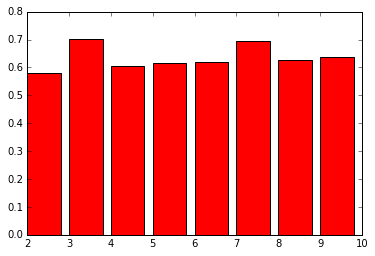

In [228]:
sil1 = range_n_clusters
sil2 = sildf['silscore']
plt.bar(sil1, sil2, color='red')

** b) 3D cluster plot**

#### Plot article distributions by cluster

In [235]:
#clust_array - **need to update this for best number of clusters**
carr = pd.DataFrame(clust_array)
carr['labels'][1]

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1], dtype=int32)

In [230]:
clust_3 = carr['labels'][1]
cdf['KMeanGroup']= clust_3
t = pd.DataFrame(data=[cdf['KMeanGroup'],cdf['Company']])
tc = t.transpose() #<---- look at cluster groups
#tc['Cols'] = cols_hex[len(cdf)]
clust_num = 3

In [231]:
# prep for plot
c1_idx = tc[tc['KMeanGroup']==0]
c2_idx = tc[tc['KMeanGroup']==1]
c3_idx = tc[tc['KMeanGroup']==2]
#c4_idx = tc[tc['KMeanGroup']==3]
#c5_idx = tc[tc['KMeanGroup']==4]
#c6_idx = tc[tc['KMeanGroup']==5]
c1_idx.index

Int64Index([0, 2, 3, 4, 5, 8, 15], dtype='int64')

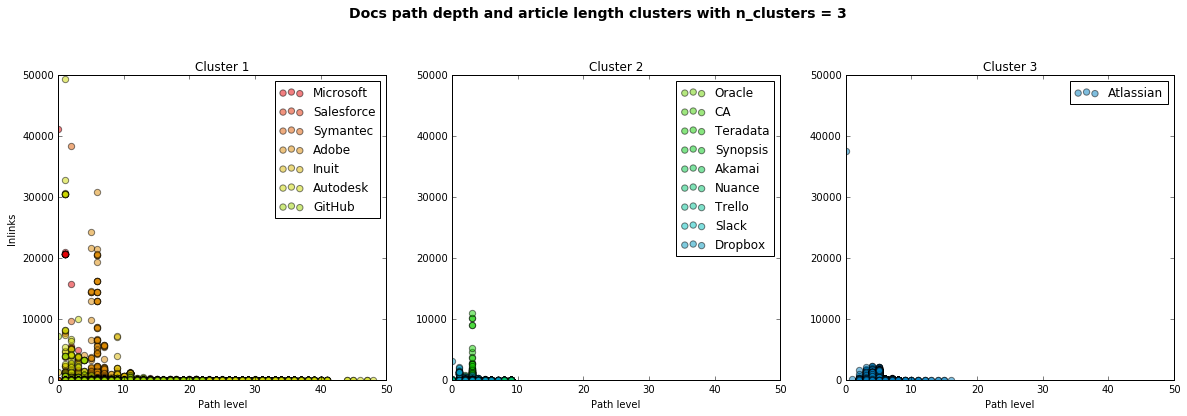

In [233]:
# Clusters = 3
plt.figure(figsize=(20, 12))
plt.suptitle(("Docs path depth and article length clusters"
                  " with n_clusters = %d" % clust_num),
                 fontsize=14, fontweight='bold')
col_cnt = -1
# Upper Left
plt.subplot(231)
for c in range(0,len(c1_idx)):
    col_cnt = col_cnt + 1
    tmpi = c1_idx.index[c]
    get_nm = c1_idx.index[c]
    tlab = c1_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.scatter(xtmpX[tmpi], xtmpY[tmpi], s=40, color=idx_col, alpha=0.5, edgecolors='black', label=name_idx[tmpi])
plt.xlim(0, 50)
plt.ylim(0, 50000)
plt.title('Cluster 1')
plt.legend(loc='upper right')
plt.ylabel(ylab)
plt.xlabel(xlab)


# Upper Mid
plt.subplot(232)
for c in range(0,len(c2_idx)):
    col_cnt = col_cnt + 1
    tmpi = c2_idx.index[c]
    get_nm = c2_idx.index[c]
    tlab = c2_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.scatter(xtmpX[tmpi], xtmpY[tmpi], s=40, color=idx_col, alpha=0.5, edgecolors='black', label=name_idx[tmpi])
plt.xlim(0, 50)
plt.ylim(0, 50000)
plt.title('Cluster 2')
plt.legend(loc='upper right')

plt.xlabel(xlab)

# Upper right
plt.subplot(233)
for c in range(0,len(c3_idx)):
    col_cnt = col_cnt + 1
    tmpi = c3_idx.index[c]
    get_nm = c3_idx.index[c]
    tlab = c3_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.scatter(xtmpX[tmpi], xtmpY[tmpi], s=40, color=idx_col, alpha=0.5, edgecolors='black', label=name_idx[tmpi])
plt.xlim(0, 50)
plt.ylim(0, 50000)
plt.title('Cluster 3')
plt.legend(loc='upper right')
plt.xlabel(xlab)

# # Mid Left
# plt.subplot(234)
# for c in range(0,len(c4_idx)):
#     col_cnt = col_cnt + 1
#     tmpi = c4_idx.index[c]
#     get_nm = c4_idx.index[c]
#     tlab = c4_idx.Company[get_nm]
#     idx_col = cols_hex[col_cnt]
#     plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
# plt.title('Cluster 4')
# plt.legend(loc='upper right')
# plt.xlabel('Article word length')
# plt.ylabel('Proportion of articles')

# # Mid Mid
# plt.subplot(235)
# for c in range(0,len(c5_idx)):
#     col_cnt = col_cnt + 1
#     tmpi = c5_idx.index[c]
#     get_nm = c5_idx.index[c]
#     tlab = c5_idx.Company[get_nm]
#     idx_col = cols_hex[col_cnt]
#     plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
# plt.title('Cluster 5')
# plt.legend(loc='upper right')
# plt.xlabel('Article word length')

# # Mid Right
# plt.subplot(236)
# for c in range(0,len(c6_idx)):
#     col_cnt = col_cnt + 1
#     tmpi = c6_idx.index[c]
#     get_nm = c6_idx.index[c]
#     tlab = c6_idx.Company[get_nm]
#     idx_col = cols_hex[col_cnt]
#     plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
# plt.title('Cluster 5')
# plt.legend(loc='upper right')
# plt.xlabel('Article word length')

plt.savefig('graphs/ALL_ArticleLengthDist_ClusterResults_01.png')

#### Cluster analysis results

Note: the cluster analysis was perfromed on normalised data wheras the graphs above plot the raw data - the cluster analysis looking at the pattern of links/paths

- Clustering appears to be primarily on the path level:
        1. Very broad path level ranges (up to 40 levels)
        2. 0-10 range
        3. 0-20 range

Q: Can you choose the slightly less successful 7 cluster result to delve into the larger 1 & 2 clusters?

### 5. Desicion tree


##### Web traffic
For whole set: Predict alexa rank from article length, external out links, in/outlinks & path depth
For company site: Predict page traffic from stats + NLP categories like topics 